# Inference for cell based approach and single fold models

Installing detectron and other necessary libraries below:

In [1]:
!pip install ../input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/antlr4-python3-runtime-4.8/antlr4-python3-runtime-4.8 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/detectron2-0.5/detectron2 --no-index --find-links ../input/detectron-05/whls 

Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272232 sha256=aba4efd7a8f9b1fb84dfa8b30398c095eb9adb4e04addc64ff629ec154cb9d5f
  Stored in directory: /root/.cache/pip/wheels/d2/09/29/2054c6cc4599cf39f1c52ce3c20bfb50be696caa5d5ba460c9
Successfully built pycocotools
Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
Processing /kaggle/in

In [2]:
import detectron2
import torch
from detectron2 import model_zoo
import tensorflow as tf
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastcore.all import *

We define a few variables and thresholds which will be used later for inference.

In [3]:
data_path = Path('../input/sartorius-cell-instance-segmentation')
model_weights_path = Path('../input/livecellweights')
single_model_weights = 'model_best_fold_1.pth'
cell_type_model_weights = {'astro' : 'model_best_astro.pth', 'cort' : 'model_best_cort.pth', 'shsy5y' : 'model_best_shsy5y.pth'}

#THRESHOLDS is the array containing class-wise thresholds which are needed for post-processing
THRESHOLDS = [.15, .35, .55]
#MIN_PIXELS is an array of thresholds that is used to discard a mask if it is below this value
MIN_PIXELS = [75, 150, 75]
CLASS_INDICES = ['astro', 'cort', 'shsy5y']

USE_SINGLE_MODEL = True

In [4]:
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_model(weights = 'imagenet'):
    '''
    weights: None for random initialization, 'imagenet' to use imagenet weights
    Returns: keras model which classifies image into cell_type
    '''
    resnet50 = tf.keras.applications.resnet50.ResNet50(
        include_top=False,
        weights= weights,
        input_shape=(704, 520, 3),
        pooling='avg'
    )

    fc1 = tf.keras.layers.Dense(128, activation='relu', name="Dense1")(resnet50.output)
    fc2 = tf.keras.layers.Dense(3, name="Dense2")(fc1)

    model = tf.keras.models.Model(inputs=resnet50.input, outputs=fc2)
    model.load_weights(str(model_weights_path / 'model_checkpoint'))
    return model

def get_masks(image_path, predictor):
    '''
    image_path: Path object containing image path
    predictor: detectron predictor object
    Returns: cleaned masks from the predictor
    '''
    image = cv2.imread(str(image_path))
    pred = predictor(image)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    score_thresh_mask = pred['instances'].scores >= THRESHOLDS[pred_class] # using different threshold per class
    pred_masks = pred['instances'].pred_masks[score_thresh_mask]
    pred_masks = pred_masks.cpu().numpy()
    
    return clean_masks(pred_masks, pred_class)

def classifier_pred(img_path):
    '''
    image_path: Path object containing image path
    Returns: the class corresponding to the image
    '''
    img = cv2.imread(str(img_path))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    img = np.expand_dims(img,0)
    img = np.swapaxes(img,1,2)
    model = get_model(weights = None)
    preds = model.predict(img)
    preds_exp = np.exp(preds - preds.max())
    del model
    return (preds_exp/preds_exp.sum()).argmax()
    
def pred_segmentation_model(model_weights, image_path, num_classes = 1):
    '''
    model_weights: name of networks weights
    image_path: Path object pointing to inference image
    num_classes: number of classes of predictor
    Returns: masks and class of the image
    '''
    predictor =  get_segmentation_model(model_weights, num_classes)
    im = cv2.imread(str(image_path))
    pred = predictor(im)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    score_threshold_mask = pred['instances'].scores >= THRESHOLDS[pred_class] # using different threshold per class
    pred_masks = pred['instances'].pred_masks[score_threshold_mask]
    pred_masks = pred_masks.cpu().numpy()
    scores = pred['instances'].scores[score_threshold_mask]
    _, pred_masks = zip(*sorted(zip(scores, pred_masks), reverse=True))
    return pred_masks, pred_class

def get_masks_cell_type(image_path, cell_class):
    '''
    image_path: Path object pointing to the inference image
    cell_class: class corresponding to the image
    Returns: cleaned masks of the cell's segementation model
    '''
    
    im = cv2.imread(str(image_path))
    pred_masks, pred_class = pred_segmentation_model(cell_type_model_weights[cell_class, image_path], 1)
    
    return clean_masks(pred_masks, pred_class)
                                                                             
def get_segmentation_model(model_weights, num_classes=1):
    '''
    model_weights: name of model_weights file
    num_classes: number of classes of the predictor
    Returns: segmentation model with loaded weights
    '''
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.INPUT.MASK_FORMAT='bitmask'
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes 
    cfg.MODEL.WEIGHTS = str(model_weights_path / model_weights)
    cfg.TEST.DETECTIONS_PER_IMAGE = 1000
    
    return DefaultPredictor(cfg)

def clean_masks(masks, _class):
    '''
    masks: list of numpy array masks
    _class: the class of the masks
    Returns: cleaned masks without overlap and noisy masks
    '''
    res = []
    used = np.zeros_like(masks[0], dtype=int) 
    for mask in masks:
        mask = mask * (1-used)
        if mask.sum() >= MIN_PIXELS[_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res

In [5]:
test_file_names = (data_path/'test').ls()

# Visualization

Visualizing the predicted masks for a test image:

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


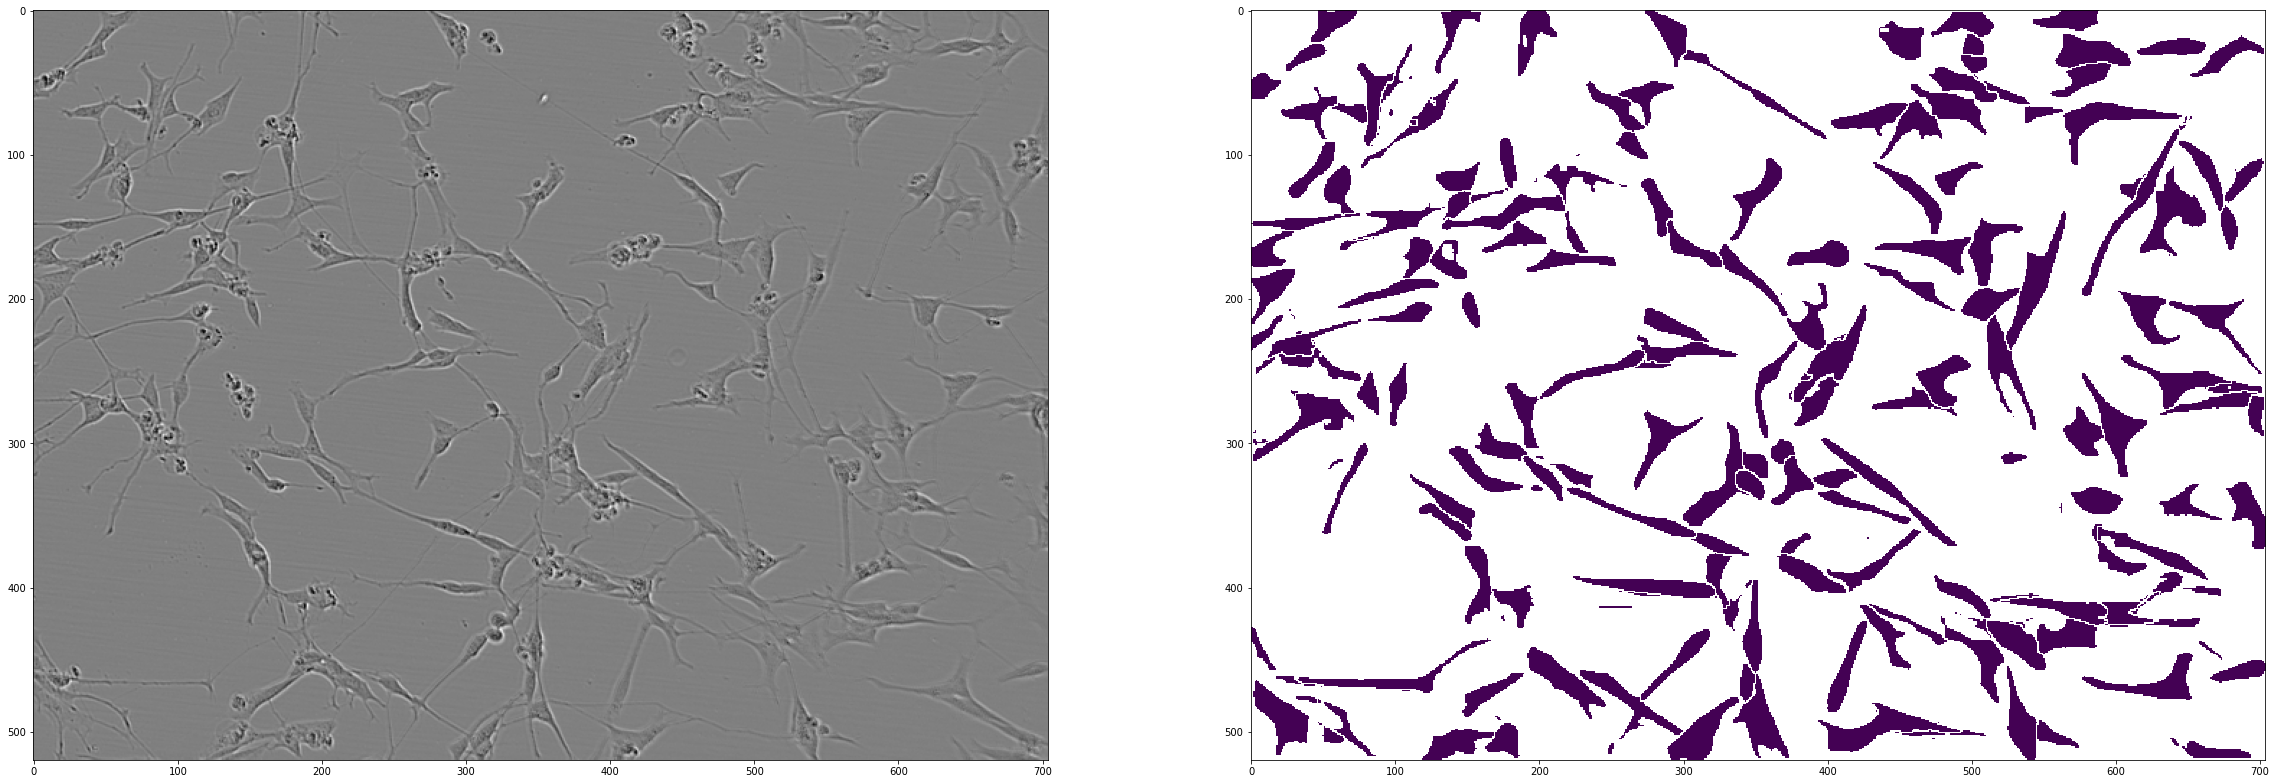

In [6]:
pred_masks, pred_class = pred_segmentation_model(cell_type_model_weights['astro'], test_file_names[0], num_classes=1)

image = cv2.imread(str(test_file_names[0]))

res = clean_masks(pred_masks, pred_class)
_, axs = plt.subplots(1,2, figsize=(40,15))
axs[0].imshow(image)
for enc in res:
    dec = rle_decode(enc)
    axs[1].imshow(np.ma.masked_where(dec==0, dec))

Generating predictions below based on whether a single model or a cell-wise model is used:

In [7]:
ids, masks = [], []

if not USE_SINGLE_MODEL:
    test_classes = [CLASS_INDICES[classifier_pred(test_name)] for test_name in test_file_names]

    for test_name, cell_type in zip(test_file_names, test_classes):
        encoded_masks = get_masks_cell_type(test_name, cell_type)
        for enc in encoded_masks:
            ids.append(test_name.stem)
            masks.append(enc)
else:
    
    model = get_segmentation_model(single_model_weights, num_classes=3)

    for test_name in test_file_names:
        encoded_masks = get_masks(test_name, model)
        for enc in encoded_masks:
            ids.append(test_name.stem)
            masks.append(enc)

In [8]:
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()

,id,predicted
0,7ae19de7bc2a,448 5 1151 7 1855 8 2558 10 3262 11 3966 12 46...
1,7ae19de7bc2a,26627 14 27329 17 28031 19 28733 21 29436 22 3...
2,7ae19de7bc2a,293184 6 293886 10 294589 13 295293 14 295997 ...
3,7ae19de7bc2a,163774 4 164476 9 165179 11 165882 13 166586 1...
4,7ae19de7bc2a,140003 15 140706 21 141410 22 142114 22 142818...
